In [1]:
import splat
import wisps
import matplotlib.pyplot as plt
from wisps.data_analysis import selection_criteria as sel_crt
from wisps.simulations import selection_function as slf
import numpy as np
import pandas as pd

import numba
import matplotlib as mpl
mpl.rcParams['font.size'] = 18

from itertools import combinations
#%%capture  output
import itertools
from tqdm import tqdm


import seaborn as sns 
cmap=sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
from tensorflow import keras

from scipy import stats

Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database


In [2]:
rfdict=pd.read_pickle(wisps.OUTPUT_FILES+'/random_forest_classifier.pkl') #the classifier 
neural_network= keras.models.load_model(wisps.OUTPUT_FILES+'/deep_model_september23.h5')
features=rfdict['feats']
#probs= neural_network
#labels=np.logical_or.reduce((probs[:, 2] > .95, probs[:,3] >.95 , probs[:,4] >0.8))


In [3]:
#cands[features]

In [4]:
%matplotlib inline

In [5]:
#read in some data
sf=pd.read_pickle(wisps.LIBRARIES+'/selection_function.pkl.gz') #the simulated spectral data

In [6]:
#selection objects 
rfdict=pd.read_pickle(wisps.OUTPUT_FILES+'/random_forest_classifier.pkl') #the classifier 
indices_to_use= pd.read_pickle(wisps.OUTPUT_FILES+'/best_indices_to_use.pkl')
neural_network= keras.models.load_model(wisps.OUTPUT_FILES+'/deep_model_september23.h5')

In [7]:
#some formatting
sampled_data=pd.DataFrame.from_records(pd.DataFrame(sf).values.flatten())
sampled_data['sp_old']=np.vstack(sampled_data.sp_old.values)[:,0]
sampled_data['spt_new']=np.vstack(sampled_data.spt_new.values)[:,0]

In [8]:
#things that missed their classification 
sampled_data['missed_label']=sampled_data['sp_old'].apply(wisps.make_spt_number) != sampled_data['spt_new'].apply(wisps.make_spt_number)
sampled_data['missed_label']=1-sampled_data.missed_label.apply(int).apply(float)
sampled_data['Names']=['spctr'+ str(idx) for idx in sampled_data.index]
sampled_data['spt']=sampled_data['sp_old'].apply(wisps.make_spt_number)

In [9]:
#selection criteria
slc_crts=sel_crt.crts_from_file()

In [10]:
indices_to_use

[('CH_4/J-Cont H_2O-1+H_2O-2/J-Cont', 'M7-L0'),
 ('H-cont/J-Cont H_2O-1+H_2O-2/H-Cont', 'L0-L5'),
 ('H-cont/J-Cont H_2O-1+H_2O-2/H-Cont', 'L5-T0'),
 ('H_2O-2/J-Cont H_2O-1+H_2O-2/H-Cont', 'T0-T5'),
 ('CH_4/H_2O-1 H_2O-1+H_2O-2/J-Cont', 'T5-T9'),
 ('H_2O-1/J-Cont H_2O-2+CH_4/J-Cont', 'Y dwarfs'),
 ('H-cont/H_2O-1 H_2O-1+CH_4/J-Cont', 'subdwarfs')]

In [11]:
#define a number of selectors 
#each selection should a column of zeros and ones corresponding
#to where objects were selected
#each selector input is the simulated df
def f_test_fx(x, df1, df2):
    return stats.f.cdf(x, df1, df2)

def select_by_indices(df, idx, spt_range):
    print(spt_range)
    bs=idx.shapes
    bx=[x for x in bs if x.shape_name==spt_range][0]
    _, bools= bx._select(np.array([df[idx.xkey].values, df[idx.ykey].values]))
    return bools
        

def apply_scale(x):
    ##remove nans 
    ##this is the same scaling used 
    ## same scaling used for 
    #replace nans
    y=x
    if np.isnan(y) or np.isinf(y) or abs(y) > 1e10:
        y=-99
    return y

def select_by_random_forest(df):
    #use the classification given by my rf classifier
    
    rf=rfdict['classifier']
    #min_max_scaler=rfdict['sclr']
    features=rfdict['feats']
    
    #apply logs to problematic features the same way I did on my classification
    pred_df=df.copy()
    
    for c in features:
        if c not in ['spt', 'f_test', 'x']:
            pred_df.assign(c=np.log10(pred_df[c].apply(apply_scale)))
        else:
            pred_df.assign(c=pred_df[c].apply(apply_scale))
            
    pred_df[features]=pred_df[features].applymap(apply_scale)
    #make predictions
    probs=rf.predict_proba(pred_df[features].values)
    labels=np.logical_or.reduce((
                                 probs[:,2] > .8, \
                                 probs[:,3] >.8 ,\
                                 probs[:,4] >0.8))
    
    #labels=np.logical_or.reduce([ probs[:, 0]<0.05, labels ])
    #labels=rf.predict(pred_df[features].values)
 
    return {'probs': probs, 'labels': labels}



def select_by_neuralnet(df):
    #define features (start with indices alone)
    #apply logs to problematic features the same way I did on my classification
    features=rfdict['feats']
    
    pred_df=df.copy()
    
    for c in features:
        if c not in ['spt']:
            pred_df.assign(c=np.log10(pred_df[c].apply(apply_scale)))
        else:
            pred_df.assign(c=pred_df[c].apply(apply_scale))
            
    pred_df[features]=pred_df[features].applymap(apply_scale)
    #probs= neural_network.predict(  pred_df[features].values)
    #need to reshape
    #probs=neural_network.predict(  pred_df[features].values.reshape(-1, len(features), 1))
    
    #my cuts
    #labels=np.logical_or.reduce((probs[:, 2] > .7, probs[:,3] >.5 , probs[:,4] >0.5))
    #labels=probs[:,0] <0.5
    #labels=neural_network.predict_classes(  pred_df[features].values.reshape(-1, len(features), 1))
    #labels=neural_network.predict(  pred_df[features].values.reshape(-1, len(features), 1))
    probs= neural_network(  pred_df[features].values, training=False)
    labels=np.logical_or.reduce((
                                probs[:, 2] > .8, \
                                 probs[:,3] >.8 ,\
                                 probs[:,4] >0.8))
    
    #labels=np.logical_or.reduce([probs[:, 1]>0.9, labels ])
    #labels=neural_network.predict_classes(  pred_df[features].values)
    #labels=np.logical_or.reduce([ probs[:, 0]<0.05, labels ])
 
    return {'probs': probs, 'labels': labels}



In [12]:
df=wisps.Annotator.reformat_table(sampled_data)
#indices
for idxk, k in indices_to_use:
    idx=slc_crts[idxk]
    df['selected_by_{}'.format(k)]= select_by_indices(df, idx, k)

M7-L0
L0-L5
L5-T0
T0-T5
T5-T9
Y dwarfs
subdwarfs


In [13]:
df['x']=df.spex_chi/df.line_chi
df['f_test']= f_test_fx(df.x, df.dof-1, df.dof-2)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


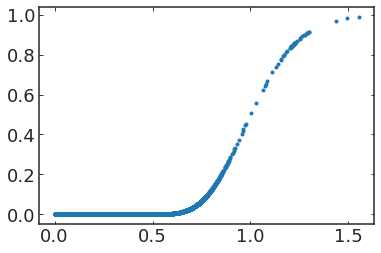

In [14]:
plt.plot(df.spex_chi/df.line_chi, df.f_test, '.')

In [15]:
df['f_test_label']=np.logical_and.reduce([df.f_test<0.02, df.x <0.5, df.snr1>=3.])

In [16]:
df

,snr1,snr2,snr3,snr4,H_2O-1/J-Cont,H_2O-1/J-Cont_er,H_2O-2/H_2O-1,H_2O-2/H_2O-1_er,H-cont/H_2O-1,H-cont/H_2O-1_er,...,spt,selected_by_M7-L0,selected_by_L0-L5,selected_by_L5-T0,selected_by_T0-T5,selected_by_T5-T9,selected_by_Y dwarfs,selected_by_subdwarfs,x,f_test_label
0,0.499550,0.527347,0.620136,0.466286,0.461276,340.241244,0.318430,115.346789,0.451722,35.601412,...,16.0,False,False,False,True,False,False,False,0.218380,False
1,790.451567,681.140545,586.462721,651.735011,1.018357,0.001814,0.774223,0.001998,0.666789,0.001454,...,16.0,False,False,False,False,False,False,True,0.179782,True
2,739.318045,635.871251,548.908679,609.047843,1.015985,0.001887,0.772109,0.002164,0.668432,0.001535,...,16.0,False,False,False,False,False,False,True,0.178201,True
3,524.267530,449.891938,389.180977,432.550142,1.020417,0.002715,0.773065,0.003035,0.665772,0.002127,...,16.0,False,False,False,False,False,False,True,0.177681,True
4,10.671102,9.191451,7.926347,8.781317,0.972485,0.130464,0.810739,0.154011,0.734960,0.116483,...,16.0,True,False,False,False,False,False,True,0.645574,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48195,992.032734,709.706880,441.833092,87.513321,0.036457,0.000829,-0.317864,0.016617,15.090121,0.334054,...,39.0,False,False,False,False,True,True,False,0.010384,True
48196,-0.367410,-0.189143,0.215426,-0.062394,0.042102,20.319807,0.026900,43.813108,-0.011115,24.379621,...,39.0,False,False,False,False,False,True,False,0.164763,False
48197,63.619214,44.848733,28.652297,6.251594,0.043352,0.013298,-0.333808,0.847524,13.025825,12.189928,...,39.0,False,False,False,False,True,True,False,0.010801,True
48198,35.661891,24.906881,17.886417,3.596588,0.017966,0.023223,-0.237303,453.443809,18.601695,791.315962,...,39.0,False,False,False,False,True,True,False,0.012375,True


In [17]:
select_by_random_forest(df)

{'probs': array([[3.53382652e-01, 0.00000000e+00, 3.97521565e-02, 6.06474025e-01,
         3.91166909e-04],
        [9.28915790e-04, 9.99056568e-01, 1.45157345e-05, 0.00000000e+00,
         0.00000000e+00],
        [9.07233333e-04, 9.99078251e-01, 1.45157345e-05, 0.00000000e+00,
         0.00000000e+00],
        ...,
        [4.54904403e-04, 0.00000000e+00, 0.00000000e+00, 9.77309446e-05,
         9.99447365e-01],
        [4.63670678e-04, 0.00000000e+00, 0.00000000e+00, 8.26091187e-05,
         9.99453720e-01],
        [9.27343756e-02, 0.00000000e+00, 0.00000000e+00, 1.36406599e-01,
         7.70859025e-01]]),
 'labels': array([False, False, False, ...,  True,  True, False])}

In [18]:
#machine learning
df['rf_label']=select_by_random_forest(df)['labels']
df['neural_net_label']=select_by_neuralnet(df)['labels']

df['rf_label']=np.logical_and(df['rf_label'], df.snr1>=3. ).apply(int)
df['neural_net_label']=np.logical_and(df['neural_net_label'], df.snr1>=3. ).apply(int)

In [19]:
#indices and total
df.f_test_label=(df['f_test_label']).apply(int)

df['index_label']=np.logical_or.reduce([df['selected_by_{}'.format(x)].values for x in  np.vstack(indices_to_use)[:,1]]).astype(int)
df['idx_ft_label']=np.logical_and(df['index_label'].apply(bool), df['f_test_label'].apply(bool) ).apply(int)


df['tot_label']=np.logical_or.reduce((df['idx_ft_label'].apply(bool), df['rf_label'].apply(bool), df['neural_net_label'].apply(bool)))
df.tot_label=np.logical_and(df.tot_label.values, (df.snr1>=3.).values).astype(int)

#put things on log-scale
df['logsnr']=df['snr1'].apply(np.log10)

In [20]:
df_small=(df[['logsnr', 'spt','tot_label']]).reset_index(drop=True).dropna().values

In [21]:
#x, y= np.meshgrid(df_small[:,0], df_small[:,1])


x= df_small[:,0]
y= df_small[:,1]
z= df_small[:,2]
xx, yy, zz = np.meshgrid(x, y,z, indexing='ij',sparse=True)

In [22]:
xx.shape, yy.shape, zz.shape

((46958, 1, 1), (1, 46958, 1), (1, 1, 46958))

In [23]:
df=df[np.logical_and(df.logsnr.between(0.36, 2), df.spt.between(16, 40))].reset_index(drop=True)

In [24]:
np.ptp(df.spt)

24.0

In [25]:
import matplotlib.colors as mcolors
import matplotlib
#mymap=mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

In [26]:
cmap='cubehelix'

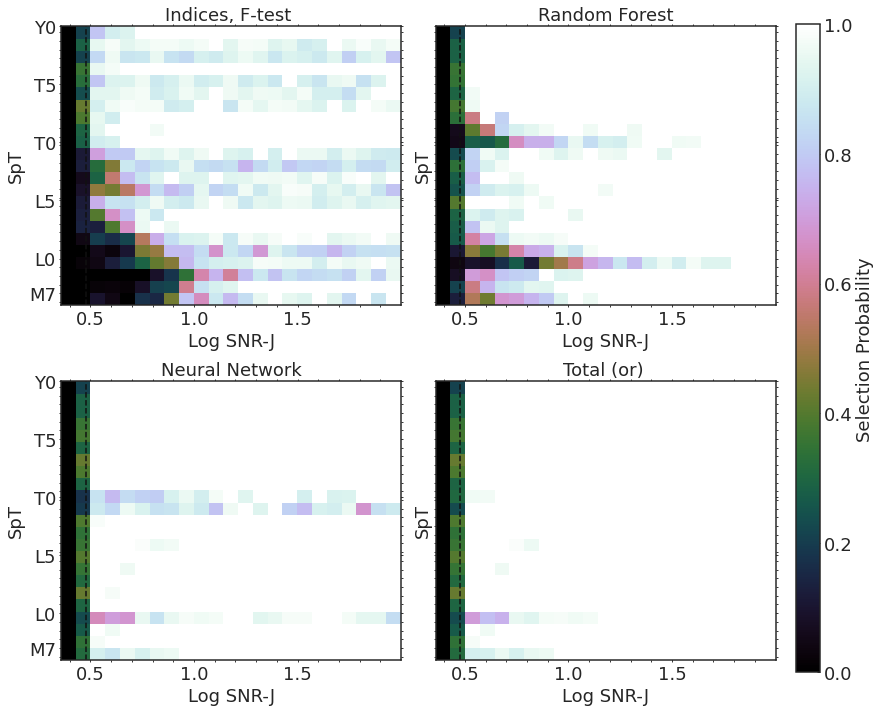

In [27]:
fig, ax=plt.subplots(ncols=2, nrows=2, figsize=(5.5*2, 5*2), 
                     sharex=False, sharey=True)
wisps.plot_annotated_heatmap(ax[0][0], df, int(np.ptp(df.spt)), ['logsnr', 'spt', 'idx_ft_label'], cmap=cmap)
wisps.plot_annotated_heatmap(ax[0][1], df, int(np.ptp(df.spt)), ['logsnr', 'spt', 'rf_label'],  cmap=cmap)
wisps.plot_annotated_heatmap(ax[1][0], df, int(np.ptp(df.spt)), ['logsnr', 'spt', 'neural_net_label'],  cmap=cmap)
wisps.plot_annotated_heatmap(ax[1][1], df, int(np.ptp(df.spt)), ['logsnr', 'spt', 'tot_label'],  cmap=cmap)
#df.plot.hexbin(x='logsnr', y='spt', C='idx_ft_label', reduce_C_function=np.nanmean, gridsize=50, cmap=cmap, ax=ax[0][0])
#df.plot.hexbin(x='logsnr', y='spt', C='rf_label', reduce_C_function=np.nanmean, gridsize=50, cmap=cmap, ax=ax[0][1])
#df.plot.hexbin(x='logsnr', y='spt', C='neural_net_label', reduce_C_function=np.nanmean, gridsize=50, cmap=cmap, ax=ax[1][0])
#df.plot.hexbin(x='logsnr', y='spt', C='tot_label', reduce_C_function=np.nanmean, gridsize=50, cmap=cmap, ax=ax[1][1])

#ax[0][0].scatter( sf.data.snr1.apply(np.log10), sf.data.spt, marker='+', color='#111111', alpha=.05)


ax[0][0].set_title('Indices, F-test ', fontsize=18)
ax[0][1].set_title('Random Forest', fontsize=18)
ax[1][0].set_title('Neural Network', fontsize=18)
ax[1][1].set_title('Total (or) ', fontsize=18)

for a in np.concatenate(ax):
    a.set_xlabel('Log SNR-J', fontsize=18)
    a.set_ylabel('SpT', fontsize=18)
    a.axvline(np.log10(3), linestyle='--', color='#111111')
    

    a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor',direction='out')
    
    a.minorticks_on()
    #a.set_yticks(np.arange(17, 42),  minor=True)
    a.set_yticks([17, 20, 25, 30, 35, 40], minor=False)
    a.set_yticklabels(['M7', 'L0', 'L5', 'T0', 'T5', 'Y0'], minor=False)
    #a.set_xlim([0., 2.3])
    #a.set_ylim([17., 42.])
    
plt.tight_layout()

cax = fig.add_axes([1.01, 0.06, .03, 0.9])
norm= matplotlib.colors.Normalize(vmin=0.0,vmax=1.0)
mp=matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar=plt.colorbar(mp, cax=cax, orientation='vertical')
cbar.ax.set_ylabel(r'Selection Probability', fontsize=18)

plt.savefig(wisps.OUTPUT_FIGURES+'/selection_function_samples.pdf', bbox_inches='tight', dpi=200)

In [28]:
#save partial of the data to use for my selection function calculations
df2=(df[['logsnr', 'tot_label', 'spt']])

In [29]:
df2.logsnr=df2.logsnr.apply(lambda x: np.round(x, 1))

In [30]:
#df2.groupby(['spt', 'logsnr'])['tot_label'].mean().plot()

In [31]:
df2.to_pickle(wisps.OUTPUT_FILES+'/selection_function_lookup_table.pkl')

In [37]:
 stats.f.cdf(1, 30000, 100)

0.4812853785272783